In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 2 자연어와 단어의 분산 표현

## 2.1 자연어 처리란
### 2.1.1 단어의 의미
## 2.2 시소러스
### 2.2.1 WordNet
### 2.2.2 시소러스의 문제점
## 2.3 통계기반기법
### 2.3.1 파이썬으로 말뭉치 전처리하기

In [2]:
text = 'You say goodbye and I say hello.'

text = text.lower()
text = text.replace('.', ' .') # 문장 끝 표현.
text

'you say goodbye and i say hello .'

In [3]:
words = text.split(' ')
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [4]:
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

In [5]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [19]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [20]:
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [21]:
# 위의 과정을 함수화. 

def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    
    words = text.split()
    
    word_to_id = {}
    id_to_text = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
            
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

In [22]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

In [23]:
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

### 2.3.2 단어의 분산 표현 (distributional representation)
### 2.3.3 분포 가설 (distributional hypothesis)

"단어의 의미는 주변 단어에 의해 형성된다."

단어의 의미는 그 자체로는 알 수 없고, 그 단어가 사용된 맥락(context)가 의미를 형성한다. 

이제부터 맥락 context는 어떤 단어의 주변의 다른 단어들을 가리킨다. 

window에 따라 그 주변 몇 칸까지 탐색할지 정할 수 있다. `window=2` 라면 양쪽 두 칸까지 본다. 

### 2.3.4 동시발생 행렬 (co-occurrence matrix)

어떤 단어 w를 주목할 때, 그 주변에 각 단어가 몇 번이나 등장하는데 세어 집계하는 방법. (statistical based approach) 

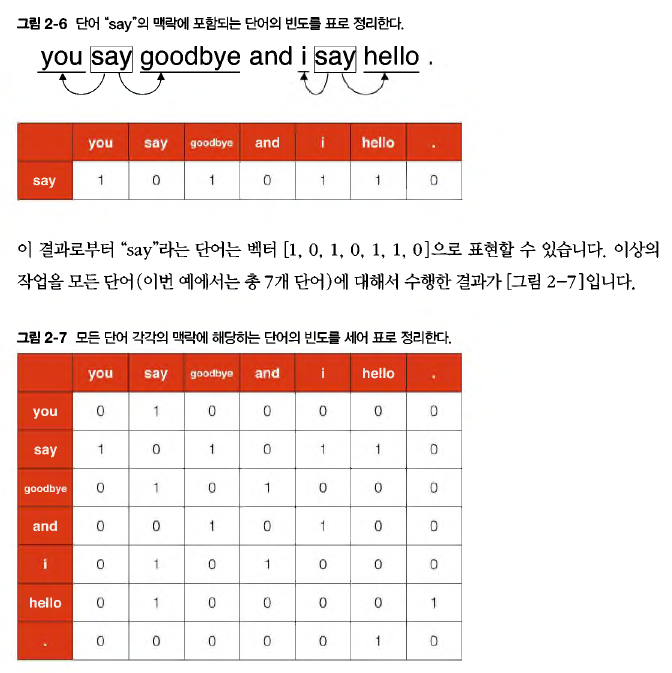

In [24]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32) # matrix 생성 및 초기화
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size+1):
            left_idx = idx - i
            right_idx = idx + i 
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    
    return co_matrix

In [25]:
create_co_matrix(corpus, len(word_to_id), )

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]])

### 2.3.5 벡터 간 유사도

단어 벡터 유사도를 나타낼 때는 cosine similarity를 자주 이용. 

분자에는 백터의 내적(dot product)이, 분모에는 각 벡터의 norm이 등장. 여기에선 L2 norm 사용. 

코사인 유사도는 직관적으로 두 벡터가 가리키는 방향이 얼마나 비슷한가를 나타낸다. 두 벡터의 방향이 완전히 같다면 1, 완전히 반대라면 -1이 된다. 

90도로 직교하면 0이 된다. 

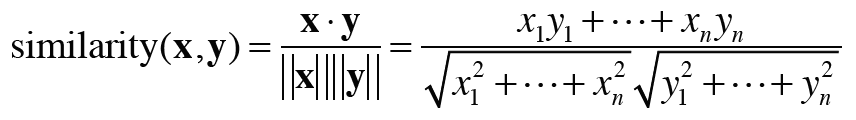

In [30]:
def cos_similarity(x, y, eps=1e-8): # zero division 을 막아주기 위해 작은 값 eps를 더한다. 
    nx = x / np.sqrt(np.sum(x**2) + eps)
    ny = y / np.sqrt(np.sum(y**2) + eps)
    return np.dot(nx, ny)

In [31]:
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]

In [32]:
cos_similarity(c0, c1)

0.7071067758832467

### 2.3.6 유사 단어의 랭킹 표시

In [33]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    # 1. 검색어를 꺼낸다. 
    if query not in word_to_id:
        print("query not in the dictionary.")
        return 
    
    print('\n[query] ' + query)
    
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    # 2. 코사인 유사도 계산
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
        
    # 3. 코사인 유사도 기준으로 내림차순 정렬
    count = 0
    for i in (-1 * similarity).argsort(): # argsort의 output은 인덱스
        if id_to_word[i] == query:
            continue
        print(f'{id_to_word[i]}: {similarity[i]}')
        
        count += 1
        if count >= top:
            return

In [34]:
# argsort 예시

x = np.array([100, -20, 2])
x.argsort()

array([1, 2, 0], dtype=int64)

In [35]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
goodbye: 0.7071067758832467
i: 0.7071067758832467
hello: 0.7071067758832467
say: 0.0
and: 0.0


말뭉치가 작기 때문에 결과가 제대로 나오지 않는다. you 와 i는 몰라도 goodbye와 hello는 you와 유사하지 않다. 

## 2.4 통계 기반 기법 개선하기 

### 2.4.1 상호정보량

동시발생만으로 단어의 similarity를 측정하는 것은 좋지 않다. the 같이 그냥 많이 나오는 (고빈도) stopwords 들도 많이 들어가게 되니까. 

따라서 점벌 상호정보량(PMI, Pointwise Mutual Information)을 사용한다. 

동시에 발생할 확률이 분자에 와서 동시발생확률을 측정하지만, 많이 등장하면 각각의 분모가 커져 penalty를 주는 방식. 

이를 C(x) == 동시발생행렬을 사용하여 다시 표현하면 

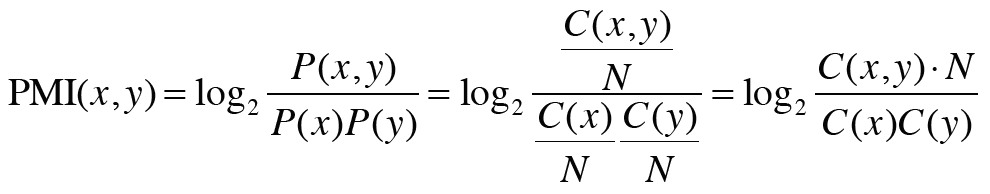

하지만 동시발생 횟수가 0이면 zero division이 발생하므로 양의 상호정보량(PPMI, Positive PMI)을 이용한다. 

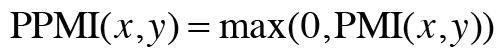

In [39]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    print(f'''
    shape of M: {M.shape}
    N: {N}
    S: {S}
    
    ''')
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi) # ppmi
            
            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% 완료' % (100*cnt/total))
    
    return M

In [40]:
W = ppmi(C)

np.set_printoptions(precision=3)

print(f'''
동시발생 행렬:
{C}
---------------
PPMI
{W}
''')


    shape of M: (7, 7)
    N: 14
    S: [1 4 2 2 2 2 1]
    
    

동시발생 행렬:
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
---------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]



동시발생행렬은 동시에 발생했다는 것만 True/False 로 주어져 있지만 

PPMI행렬은 동시에 일어날 확률 정보가 같이 들어있다. 

### 2.4.2 차원 감소 Dimensionality Reduction

PPMI 행렬의 어휘 수가 증가하면 각 단어 벡터의 차원 수도 증가한다. 어휘 수가 10만이면 벡터의 차원 수도 10만이 된다. 

차원의 저주. 차원 감소가 필요하다.

감소시킬 때는 최대한 분산을 크게 하는 축을 찾아야 한다. (중요한 정보는 최대한 유지해야 한다.) 

SVD(Singular Value Decomposition, 특이값 분해)를 쓰도록 한다. 

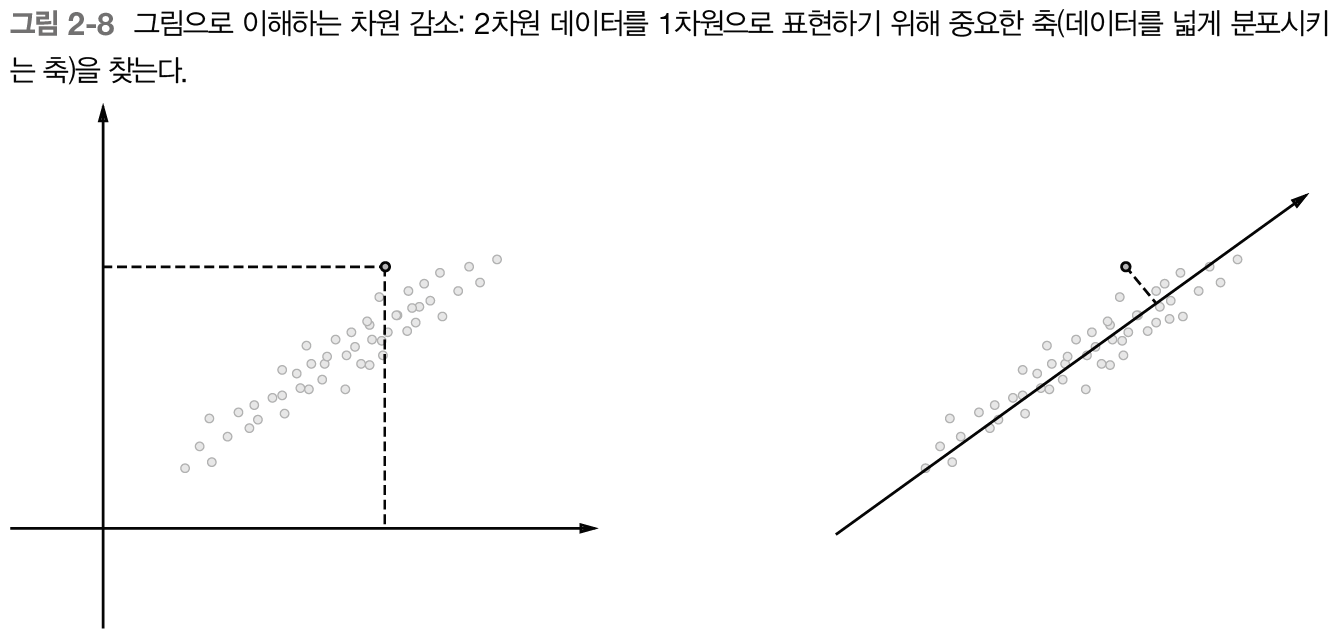

데이터의 분산을 가장 크게 하는 축을 찾아 이 축에 데이터를 사영한 값이 차원 축소한 값이다. 

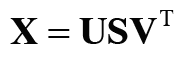

U: orthogonal matrix 직교 행렬 vector space의 basis를 형성. 각 축이 직교함. 여기선 U를 '단어 공간'으로 취급할 수 있다. 

S: diagonal matrix 대각행렬 (대각성분 외에는 모두 0). 특이값 singular values들이 큰 순서로 나열되어 있음. 특이값 = 축의 중요도 라고 할 수 있다. 

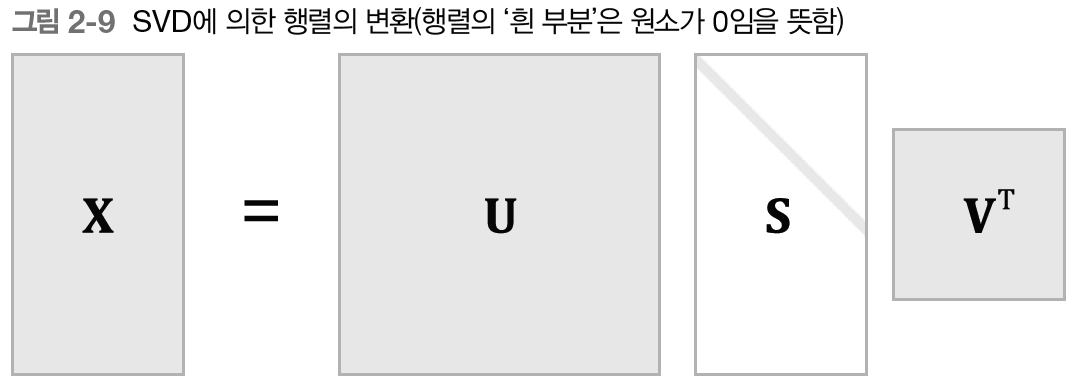

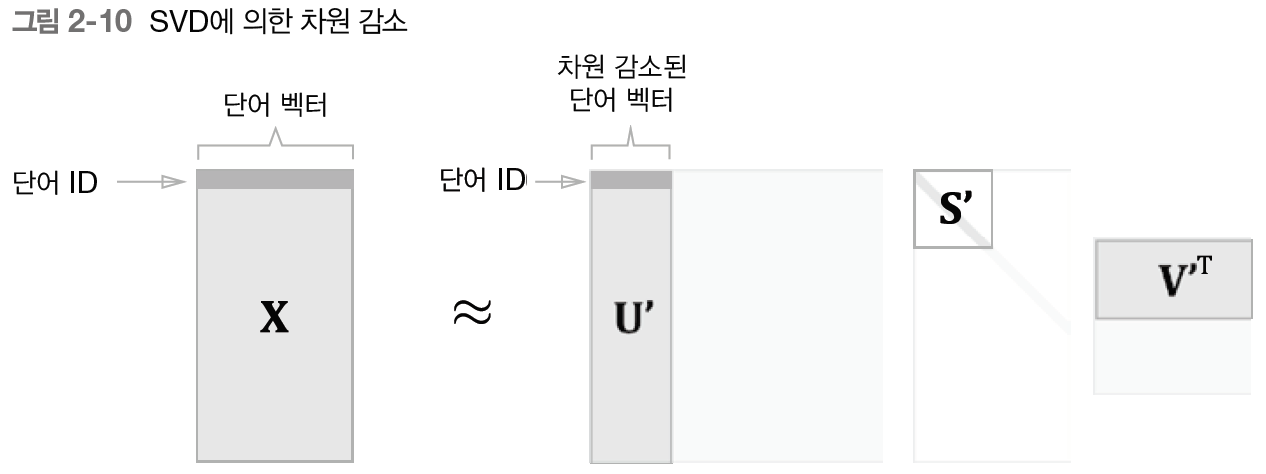

### 2.4.3 SVD에 의한 차원 감소

희소벡터인 W를 밀집벡터인 U로 변화시킨다. 

하지만 SVD는 O(n^3)의 시간복잡도를 가진다. 따라서 Truncated SVD와 같은 더 빠른 기법을 이용한다. 

In [41]:
# SVD
U, S, V = np.linalg.svd(W)

word id == 0 인 단어를 예로 살펴보자. 

In [42]:
# 동시 발생 행렬
C[0] 

array([0, 1, 0, 0, 0, 0, 0])

In [45]:
# PPMI
W[0]

array([0.   , 1.807, 0.   , 0.   , 0.   , 0.   , 0.   ], dtype=float32)

In [46]:
# SVD
U[0]

array([-3.409e-01, -1.110e-16, -3.886e-16, -1.205e-01,  0.000e+00,
        9.323e-01,  2.226e-16], dtype=float32)

In [50]:
U[0, :2] # 2차원 벡터로 줄인다. 

array([-3.409e-01, -1.110e-16], dtype=float32)

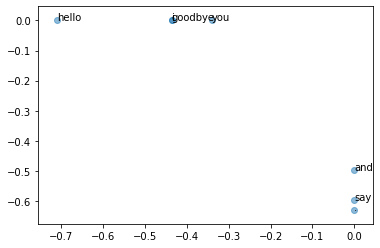

In [54]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

### 2.4.4 PTB(Penn Treebank) 데이터셋

PTB말뭉치는 주어진 기법의 품질 측정 벤치마크로 자주 이용된다. 

결과 생략.

### 2.4.5 PTB 데이터셋 평가

Truncated SVD 중 하나인 `sklearn`의 `.randomized_svd()`를 사용한다. 

## 2.5 정리

- WordNet 등의 시소러스를 이용하면 유의어를 얻거나 단어 사이의 유사도를 측정하는 등 유용한 작업을 할 수 있다. 
- 시소러스 기반 기법은 시소러스를 작성하는 데 엄청난 인적 자원이 든다거나 새로운 단어에 대응하기 어렵다는 문제가 있다. 
- 현재는 말뭉치를 이용해 단어를 벡터화하는 방식이 주로 쓰인다. 
- 최근의 단어 벡터화 기법들은 대부분 '단어의 의미는 주변 단어에 의해 형성된다'는 분포 가설에 기초한다. 
- 통계 기반 기밥은 말뭉치 안의 각 단어에 대해서 그 단어 주변 단어의 빈도를 집계한다. (동시발생행렬)
- 동시발생행렬을 PPMI행렬로 변환하고 다시 차원을 감소시킴으로써, 거대한 '희소벡터'를 작은 '밀집벡터'로 변환할 수 있다. 
- 단어의 벡터 공간에서는 의미가 가까운 단어는 그 거리도 가까울 것으로 기대된다. 